## Reimplementation Structurally constrained recurrent nets (SCRN) by Keras

This model is proposed by Tomas Mikolov, Armand Joulin, Sumit Chopra, Michael Mathieu, and Marc'Aurelio Ranzato. [Learning Longer Memory in Recurrent Neural Networks](http://arxiv.org/abs/1412.7753).

In [1]:
import numpy as np
np.random.seed(13)

from keras import backend as K
from keras.models import Model
from keras.layers import Dense, Embedding, LSTM, SimpleRNN, Lambda, Input, Recurrent, TimeDistributed, Activation
from keras.layers.merge import Add
from keras.engine import InputSpec
from keras.utils import np_utils
from keras.utils.data_utils import get_file
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import Callback
from keras.utils.vis_utils import plot_model, model_to_dot
from keras.legacy import interfaces

from IPython.display import SVG
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def sample(p):
    p[0] = 0.
    p /= sum(p)
    return np.argmax(np.random.multinomial(1, p, 1))

In [3]:
class ContextRNN(Recurrent):

    @interfaces.legacy_recurrent_support
    def __init__(self, units, alpha=0.95, **kwargs):
        if alpha < 0. or alpha > 1.:
            raise ValueError('you must set  `0. <= alpha <= 1.`.')
        super(ContextRNN, self).__init__(**kwargs)        
        self.units = units
        self.alpha = K.variable(alpha)            

    def build(self, input_shape):
        if isinstance(input_shape, list):
            input_shape = input_shape[0]

        batch_size = input_shape[0] if self.stateful else None

        self.input_dim = input_shape[2]
        self.input_spec[0] = InputSpec(shape=(batch_size, None, self.input_dim))
        
        self.states = [None]
        if self.stateful:
            self.reset_states()
        
        self.built = True

    def step(self, inputs, states):
        prev_output = states[0]
        output = (1.-self.alpha)*inputs + (self.alpha)*prev_output
        return output, [output]

    def get_config(self):
        config = {'units': self.units,
                  'alpha': self.alpha}

        base_config = super(ContextRNN, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
path = get_file('alice.txt', origin='http://www.gutenberg.org/cache/epub/11/pg11.txt')
doc = open(path).readlines()
doc = ['<bos> {} <eos>'.format(sentence) for sentence in doc if sentence.count(' ') > 2]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(doc)
doc = tokenizer.texts_to_sequences(doc)
V = len(tokenizer.word_index)+1
index2word = {v: k for k, v in tokenizer.word_index.items()}

In [5]:
data = []
targets = []
for sentence in doc:
    for i in range(1, len(sentence)):
        start = 0
        data.append(sentence[start:i])
        targets.append(sentence[i])

ys = np_utils.to_categorical(targets, V)
maxlen = max(map(len, data))
xs = sequence.pad_sequences(data, maxlen=maxlen)
print(xs.shape, ys.shape)

(33144, 19) (33144, 3380)


In [6]:
def get_RNN_last(x):
    return x[:, -1, :]

def get_RNN_last_shape(input_shape):
    assert len(input_shape) == 3
    return (None, input_shape[-1])

In [7]:
num_hidden = 100
num_context = 40
m = 100
w = Input(shape=(maxlen,), dtype='int32', name='x')

#slow
b = Embedding(output_dim=num_context, input_dim=V, input_length=maxlen, name='Bx')(w)
s = ContextRNN(units=num_context, return_sequences=True, name='s')(b)
ps = TimeDistributed(Dense(m), name='Ps')(s)

s = Lambda(lambda x: get_RNN_last(x), output_shape=get_RNN_last_shape, name='s_T')(s)
v = Dense(V, name='Vs')(s)

# fast
x = Embedding(output_dim=m, input_dim=V, input_length=maxlen, name='Ax')(w)
x = Add()([x, ps])

x = SimpleRNN(num_hidden, activation='sigmoid', return_sequences=False, name='h')(x)
x = Dense(V)(x)
x = Add()([x,v])
y = Activation("softmax", name='y')(x)

model = Model(inputs=w, outputs=y)

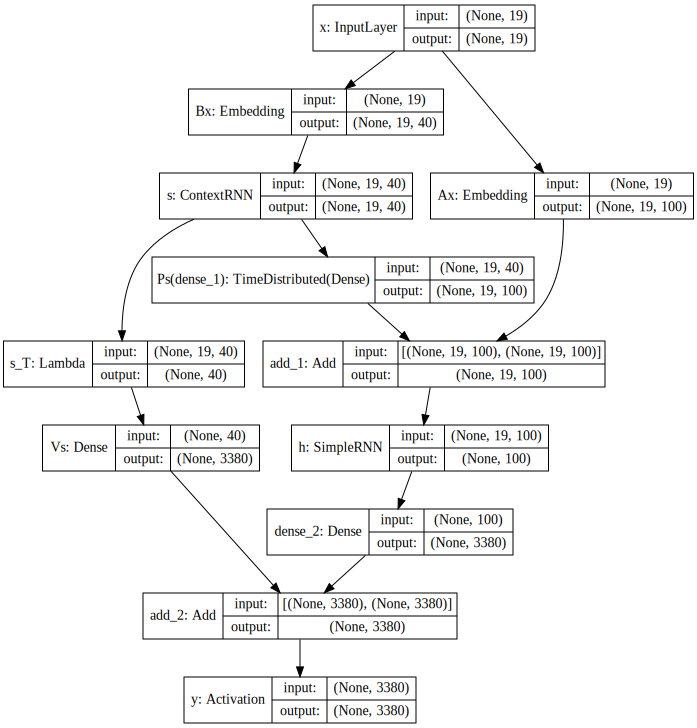

In [8]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

In [10]:
class PrintGeneratedText(Callback):
    def __init__(self, index2word):
        self.index2word = index2word
        super(PrintGeneratedText, self).__init__()
        
    def on_epoch_end(self, epoch, logs={}):
        words = ['bos']
        for _ in range(maxlen):
            x = sequence.pad_sequences(tokenizer.texts_to_sequences([' '.join(words)]), maxlen=maxlen)
            word_id = sample(model.predict(x)[0])
            word = self.index2word[word_id]
            words.append(word)
            if word == 'eos':
                break
        print(' '.join(words[1:-1]))

In [11]:
model.fit(xs, ys, batch_size=128,
          epochs=32, validation_split=0.2,
          callbacks=[PrintGeneratedText(index2word=index2word)],
          verbose=0)

sat horse closer ‘you’d about it any not’ why house seen close doesn’t get a an of they’d
she dinner who was
brown as the were you trials doesn’t said i had he
so a the ready i’ve
distance alice very long rather pegs of never as high alice
the the it the she rabbit that her crowded attending ‘stand
the grin straight soldiers sea could the slippery don’t you a time dormouse a now english
door next are ’ ‘did me dish is five of turtle ’ of of and
of alice began heads i cat it increasing was she ‘you to
france who for sheep and rather directions like of itself might
’ and having blow mean ’ a lovely
queen the hedgehog shutting this it was “i could alice rather to poor and
beautiful angrily up the eaten shall ’ she very ‘off doth
could gloves ’ said ’ off thought the little eagerly ‘what like
‘i ’ that the lobsters to get me half said screaming low was gryphon oh after called very
turning angrily did again on said the ‘allow little herself her is
my idiotic the behind busily they’re to eno

## Random sampling

In [12]:
def generate_text(text):
    results = text.split()
    for _ in range(maxlen):
        x = sequence.pad_sequences(tokenizer.texts_to_sequences([' '.join(results)]), maxlen=maxlen)
        word_id = sample(model.predict(x)[0])
        word = index2word[word_id]
        results.append(word)
        if word == 'eos':
            break
    return ' '.join(results[1:-1])

In [13]:
for i in range(30):
    print(i, generate_text(text='bos alice'))
    

0 alice five herself listeners not have should tone that ’ she going of
1 alice ‘it spoke rush table herself tidy be quite very turtle
2 alice thing on all this so to one more such
3 alice tell she yet hand ’ as the was anyone ‘if her
4 alice said his very never’ again with be changed so it was deal too
5 alice then ’ nothing the shoulders ’ she the a cucumber
6 alice said alice and gloomily knew him to
7 alice as at its interest was use a way for she had the
8 alice shut ‘you’re ‘where confusing it not that at even all let
9 alice with itself girl a appear in interesting the manage at nothing the left
10 alice agree she cake
11 alice their look to what uglify ’ said the song mentioned green a reason
12 alice but it’s for down in the voice ‘for
13 alice cat where kid tray soon that real you every turtle would ‘for ‘call to and injure in
14 alice ”’ ’ to the at of on a gryphon of i’m matter to find up
15 alice busily ‘boots the were little moral of your she ‘it up a king
16 alice rate a

In [14]:
for i in range(30):
    print(i, generate_text(text='bos'))
    

0 simpleton question sort on a king of wild again i
1 suppose with the right ‘then never over the shrinking labelled do in up set
2 she think to afraid couldn’t being
3 to was and “you off ’ said the argued back in say
4 machines ‘i had right some pronounced how with ’ said the at
5 the because right very refund” are you’re would
6 and your shorter things then time the gryphon sudden the hare
7 any ’ the felt such squeeze as ‘because pigs the rude
8 ringlets i’d figure chuckled and by he poor came at ‘but the tea of may
9 knee and the yourself full again said the think
10 rule into the little glass hot question on going lessons ‘if in the were
11 it pennyworth the rabbit she read what sensation now she only ‘you’ll to golden distributing playing
12 shared not well ’ said a queen of the ravens
13 said but she for and air shyly wasn’t will suddenly ’ and air in
14 difficult she gravy were ’ said the gryphon ’ she freely give
15 size the writing i wrong to her one anything she speak
16 ’ 

## Maximum

In [15]:
words = ['bos', 'alice']
for _ in range(maxlen):
    x = sequence.pad_sequences(tokenizer.texts_to_sequences([' '.join(words)]), maxlen=maxlen)
    word_id = np.argmax(model.predict(x)[0])
    word = index2word[word_id]
    words.append(word)
    if word == 'eos':
        break
print(' '.join(words[1:-1]))

alice ’ said the mock turtle ’ said the
